In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import panda_datasets, panda_baseline_models, panda_baseline_training
from lib.ekf import KalmanFilterNetwork
from fannypack import utils
from lib import dpf
from lib.panda_models import PandaDynamicsModel, PandaEKFMeasurementModel
from lib.fusion import CrossModalWeights
import lib.panda_kf_training as training
from lib.fusion import KalmanFusionModel



In [5]:
# Experiment configuration
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
    'image_blackout_ratio':0.4
}

In [6]:
experiment_names = ["fusion_poe_blackout_0.4_0", "fusion_poe_blackout_0.4_0"]
fusion_type = ["poe", "weighted"]


In [7]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

# eval_trajectories = eval_trajectories[70:90]

In [8]:
# image_modality_model
image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=64)
image_dynamics = PandaDynamicsModel(use_particles=False)
image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# force_modality_model
force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=64)
force_dynamics = PandaDynamicsModel(use_particles=False)
force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

weight_model = CrossModalWeights()

fusion_models = []
buddies = []

for i, f_type in enumerate(fusion_type):
    model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
    buddy = fannypack.utils.Buddy(experiment_names[i],
                                  model,
                                optimizer_names=["im_meas", "force_meas",
                                "im_dynamics", "force_dynamics",
                                "force_ekf", "im_ekf",
                                "fusion"],
                                  load_checkpoint=True,
                                  )
    buddy.load_checkpoint("phase_4_fusion")
    fusion_models.append(model)
    buddies.append(buddy)



[buddy-fusion_poe_blackout_0.4_0] Using device: cuda
[buddy-fusion_poe_blackout_0.4_0] Loaded metadata: {'batch': 128, 'epochs': 1, 'hidden_units': 64, 'image_blackout_ratio': 0.4, 'init state noise': 0.2, 'loading checkpoint': None, 'many loss': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'start training from': 'all', 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-fusion_poe_blackout_0.4_0] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.4_0-0000000000128145.ckpt
[buddy-fusion_poe_blackout_0.4_0] Loaded checkpoint at step: 128145
[buddy-fusion_poe_blackout_0.4_0] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.4_0-phase_4_fusion.ckpt


/scr-ssd/filter/fannypack/fannypack/utils/_buddy_mixins/_checkpointing.py:252: UserWarning: Checkpoint loading: overriding optimizer names.
  warnings.warn("Checkpoint loading: overriding optimizer names.")


[buddy-fusion_poe_blackout_0.4_0] Loaded checkpoint at step: 128145
[buddy-fusion_poe_blackout_0.4_0] Using device: cuda
[buddy-fusion_poe_blackout_0.4_0] Loaded metadata: {'batch': 128, 'epochs': 1, 'hidden_units': 64, 'image_blackout_ratio': 0.4, 'init state noise': 0.2, 'loading checkpoint': None, 'many loss': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'start training from': 'all', 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-fusion_poe_blackout_0.4_0] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.4_0-0000000000128145.ckpt
[buddy-fusion_poe_blackout_0.4_0] Loaded checkpoint at step: 128145
[buddy-fusion_poe_blackout_0.4_0] Read checkpoint from path: checkpoints/fusion_poe_blackout_0.4_0-phase_4_fusion.ckpt
[buddy-fusion_poe_blackout_0.4_0] Loaded checkpoint at step: 128145


In [9]:
# # image_modality_model
# image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=128)
# image_dynamics = PandaDynamicsModel(use_particles=False)
# image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# # force_modality_model
# force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=128)
# force_dynamics = PandaDynamicsModel(use_particles=False)
# force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

# weight_model = CrossModalWeights()

# fusion_models = []
# buddies = []

# f_type="poe"
# i = 2
# model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
# buddy = fannypack.utils.Buddy(experiment_names[i],
#                               model,
#                             optimizer_names=["im_meas", "force_meas",
#                             "im_dynamics", "force_dynamics",
#                             "force_ekf", "im_ekf",
#                             "fusion"],
#                               load_checkpoint=True,
#                               )
# fusion_models.append(model)
# buddies.append(buddy)


Fusion Model: poe
(10, 240, 2)


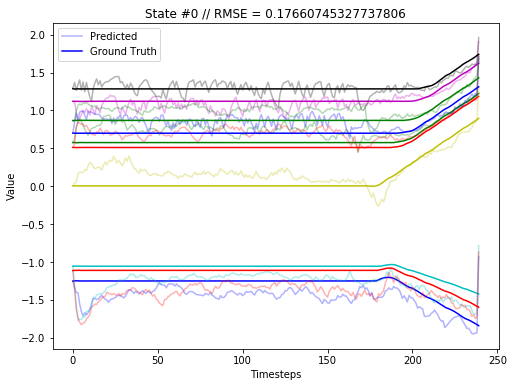

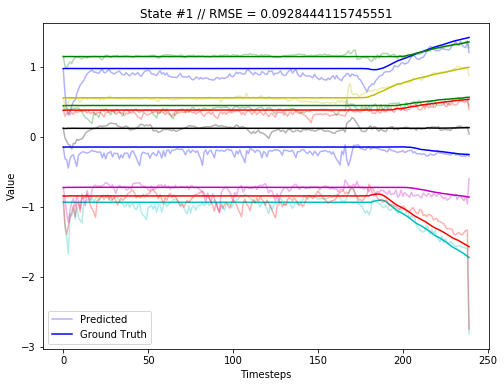


Fusion Model: weighted
(10, 240, 2)


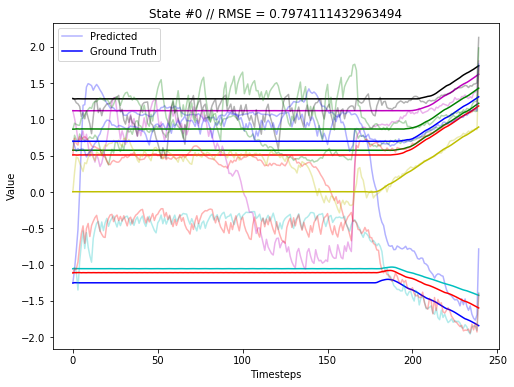

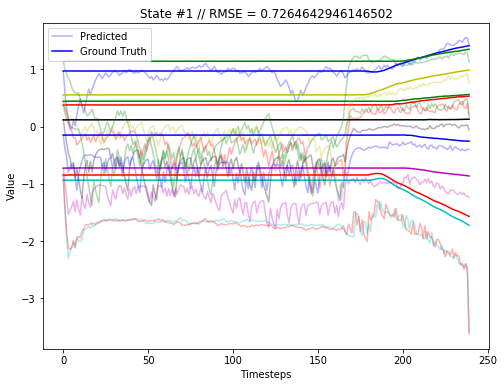

In [13]:

for i in range(len(fusion_models)):

    print("Fusion Model: {}".format(fusion_type[i])) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, true_initial=True, init_state_noise=0.0)
    training.eval_rollout(pred, actual, plot=True)
    print("")

In [11]:
experiment_name = "fusion_ekf_blackout_0.4_0"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
    'image_blackout_ratio': 0.4
}
measurement = PandaEKFMeasurementModel()
dynamics = PandaDynamicsModel(use_particles=False)
ekf = KalmanFilterNetwork(dynamics, measurement)
print("Creating model...")
buddy = fannypack.utils.Buddy(experiment_name,
                              ekf,
                              optimizer_names=["ekf", "dynamics", "measurement"],
                              load_checkpoint=True,
                              )

buddy.load_checkpoint("phase_3_e2e")

Creating model...
[buddy-fusion_ekf_blackout_0.4_0] Using device: cuda
[buddy-fusion_ekf_blackout_0.4_0] Read checkpoint from path: checkpoints/fusion_ekf_blackout_0.4_0-0000000000115670.ckpt
[buddy-fusion_ekf_blackout_0.4_0] Loaded checkpoint at step: 115670
[buddy-fusion_ekf_blackout_0.4_0] Read checkpoint from path: checkpoints/fusion_ekf_blackout_0.4_0-phase_3_e2e.ckpt
[buddy-fusion_ekf_blackout_0.4_0] Loaded checkpoint at step: 115670


True

(10, 240, 2)


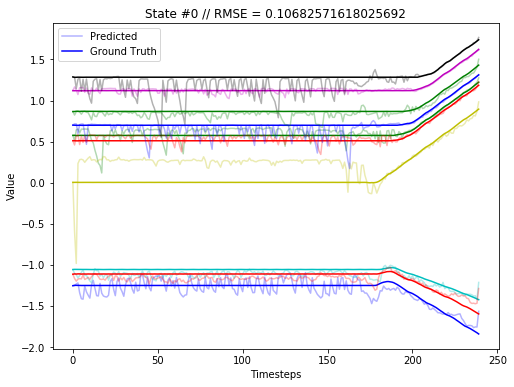

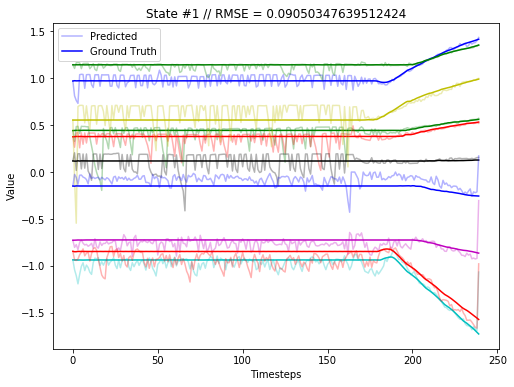

In [14]:
pred, actual = training.rollout_kf(ekf, eval_trajectories, true_initial=True, init_state_noise=0.0)
training.eval_rollout(pred, actual, plot=True)